# SPASE Record Analysis - How to Use <br>
Author: Zach Boquet

**START HERE**. For more documentation on how to add to this project, view the related notebook subtitled "How to Add New Extracted Items or New Tests." <br>
<br>
This project aims to aid in analyzing FAIR for the SPASE records in the NumericalData and DisplayData categories.<br>

This notebook shows you how to convert desired SPASE record fields into a SQLite database. The desired fields correspond to metadata extracted from XML files using ElementTree. Also shown is how to query data from said database. <br> 
- The tutorial I used to implement ElementTree is <a href="https://realpython.com/python-xml-parser/" target="_blank">https://realpython.com/python-xml-parser/</a>. 
- If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Note that this code was extensively tested on the NASA SPASE Github repo, so inputting other SPASE Github repos may not work. Code was tested in Summer 2024 on SPASE version 2.6.1*

First, clone the NASA SPASE Github Repository <a href="https://github.com/hpde/NASA/tree/master" target="_blank">https://github.com/hpde/NASA/tree/master</a> by executing the following code. Lastly, make sure you have the necessary packages and Python scripts imported below, which can be found in the same repo you found this notebook, linked again here: <a href="https://github.com/Kurokio/HDRL-Internship-2024" target="_blank">https://github.com/Kurokio/HDRL-Internship-2024</a>.

This program takes ~3.88 minutes (233 seconds) to fully run from scratch.

You can also run the program using older database files found in the repo history. Simply change the name of the parameter to the create_sqlite_database function in the first cell to the name of the .db file you wish to use.

In [1]:
# clone NASA SPASE Github Repo
! git clone -b master --single-branch --depth=1 https://github.com/hpde/NASA

Also to be done before diving in is to install the Scripts module using pip install.

*Note that this command must be run using Python in the directory above the current directory*
```python
pip install -e ./HDRL-Internship-2024
```

## Scraping the SPASE records and populating our tables
<br>
This code block performs the following: <br>

- takes the absolute path of a SPASE directory they wish to be scraped as an argument<br>
- finds all desired metadata <br>
- creates all needed tables <br>
- adds an entry for each record found into the MetadataEntries table. <br>
- stores the locations of where each metadata field is found in the MetadataSources table <br>
- adds entries into the Records table with general info and info needed for database maintenance.<br>
- populate the TestResults table with default values. <br>
- update the columns associated with a given analysis test (i.e records that have authors -> has_author column) to have a 'True' value of 1.<br>
<br>

If you want a full printout of everything being done, pass True as the printFlag argument to Create.<br>

Examples are also found as comments at the bottom of the code block to test smaller, yet complex directories.<br>

*Note that this code was designed to work for the NumericalData and DisplayData directories, so inputting directories besides those two may cause logical errors and produce unintended results.*

In [1]:
import Scripts
from Scripts import create_sqlite_database

# input abs path of database file you wish to query from
conn = create_sqlite_database("/home/jovyan/HDRL-Internship-2024/SPASE_Data_20240716.db")

In [2]:
# import main Python function
from Scripts import Create
#from SQLiteFun import executionALL

help(Create)

Help on function Create in module Scripts.main:

Create(folder, conn, printFlag=False)
    Scrapes all records that are found in the directory given for the desired metadata. Creates the MetadataEntries, 
    MetadataSources, Records, and TestResults tables and populates them using the data scraped for each record. 
    Populates the TestResult table with default values to be overwritten by the call to the FAIRScorer function
    in the notebook.
    
    :param folder: The absolute file path of the SPASE record/directory containing the record(s) the user wants scraped.
    :type folder: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param printFlag: A boolean determining if the user wants to print more details of what the function is doing.
    :type printFlag: Boolean
    :return: None



In [ ]:
# run these lines first if want to start from scratch
#from Scripts import executionALL
#executionALL("DROP TABLE MetadataEntries", conn)
#executionALL("DROP TABLE MetadataSources", conn)
#executionALL("DROP TABLE Records", conn)
#executionALL("DROP TABLE TestResults", conn)

# updates current records from this directory in the MetadataEntries table
Create('/home/jovyan/NASA/NumericalData', conn)
Create('/home/jovyan/NASA/DisplayData', conn)

# test paths : 
# Overall paths: /home/jovyan/NASA/NumericalData 
# AND /home/jovyan/NASA/DisplayData

# Smaller subdirectory = "/home/jovyan/NASA/NumericalData/DE2" 
# OR Bigger subdirectory = "/home/jovyan/NASA/NumericalData/ACE"

# complex author ex: /home/jovyan/NASA/NumericalData/Cassini/MAG/PT60S.xml 
# OR /home/jovyan/NASA/NumericalData/ACE/Attitude/Definitive/PT1H.xml

# complex URL ex: /home/jovyan/NASA/NumericalData/ACE/CRIS/L2/P1D.xml


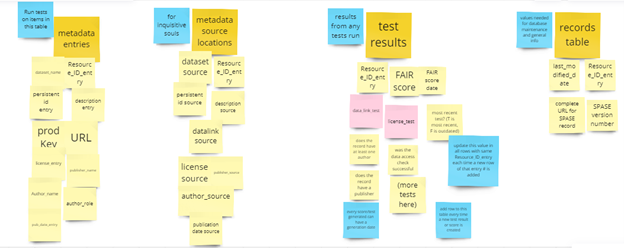

### Understanding the structure
This code block shows you all the table names and their column names in the database that was used.

In [2]:
from Scripts import databaseInfo

help(databaseInfo)

Help on function databaseInfo in module Scripts.SQLiteFun:

databaseInfo(conn)
    Prints all table names and all the names of their associated columns
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: None



In [3]:
databaseInfo(conn)

The table MetadataEntries has columns:
['rowNum', 'SPASE_id', 'author', 'authorRole', 'publisher', 'publicationYr', 'datasetName', 'license', 'URL', 'prodKey', 'description', 'PID']

The table MetadataSources has columns:
['rowNum', 'SPASE_id', 'author_source', 'publisher_source', 'publication_yr_source', 'datasetName_source', 'license_source', 'datalink_source', 'description_source', 'PID_source']

The table TestResults has columns:
['rowNum', 'SPASE_id', 'FAIR_Score', 'FAIR_ScoreDate', 'MostRecent', 'has_author', 'has_pub', 'has_pubYr', 'has_datasetName', 'has_license', 'has_url', 'has_NASAurl', 'has_PID', 'has_desc', 'has_citation', 'has_compliance', 'Errors']

The table Records has columns:
['rowNum', 'SPASE_id', 'SPASE_Version', 'LastModified', 'SPASE_URL']



## Executing Analysis Tests and Viewing the Results <br>
In this code block, we perform calls to the QueryPrinter script to get the Counts and/or ID's of the SPASE records that pass each analysis test. 
These analysis tests include links that have: <br> 

- authors <br>
- publishers <br>
- publication years <br>
- dataset names <br>
- licenses <br>
- URLs <br>
- NASA URLs <br>
- persistent identifiers <br>
- descriptions <br>
- citation info <br>
- DCAT-3 compliance info.<br>

In [2]:
from Scripts import View

help(View)

Help on function View in module Scripts.main:

View(conn, All=True, desired=['all', 'author', 'pub', 'pubYr', 'datasetName', 'license', 'url', 'NASAurl', 'PID', 'description', 'citation', 'compliance'])
    Prints the number of records that meet each test criteria provided as well as return those SPASE_id's
    to the caller in the form of a dictionary. The keys are the Strings passed as parameters and the
    values are the list of SPASE_id's that fulfill that test.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param All: A boolean determining if the records returned will be from the set containing
                all records present in the database or only those with NASA URLs.
    :type All: Boolean
    :param desired: A list of Strings which determine the kind of records whose counts are printed and whose
                        SPASE_id's are assigned to the dictionary returned. The default value is all kinds.
    :param type: li

### Analysis for All Records

In [3]:
# this function returns all records that pass associated tests 
# and prints the counts of those that pass the test specified in argument

# example that returns values for one test
records = View(conn, desired = ['citation'])
citationRecords = records["citation"]

There are 1883 records with citation info.


In [6]:
# example that returns values for 3 tests
records = View(conn, desired = ['citation', 'pub', 'compliance'])
citationRecords = records["citation"]
pubRecords = records["pub"]
complianceRecords = records["compliance"]

There are 1883 records with citation info.
There are 3033 records with a publisher.
There are 1863 records that meet DCAT-US3 compliance.


In [5]:
# example that returns values for all tests
records = View(conn)
allRecords = records["all"]
authorRecords = records["author"]
pubRecords = records["pub"]
pubYrRecords = records["pubYr"]
datasetNameRecords = records["datasetName"]
licenseRecords = records["license"]
urlRecords = records["url"]
NASAurlRecords = records["NASAurl"]
PIDRecords = records["PID"]
descriptionRecords = records["description"]
citationRecords = records["citation"]
complianceRecords = records["compliance"]

There are 3033 records total.
There are 2906 records with an author.
There are 3033 records with a publisher.
There are 1883 records with a publication year.
There are 3033 records with a dataset.
There are 0 records with a license.
There are 3033 records with a URL.
There are 2253 records with a NASA URL.
There are 1863 records with a persistent identifier.
There are 3033 records with a description.
There are 1883 records with citation info.
There are 1863 records that meet DCAT-US3 compliance.


In [3]:
from Scripts import MetadataBarChart

help(MetadataBarChart)

Help on function MetadataBarChart in module Scripts.PlotScripts:

MetadataBarChart(conn, records, percent=False, All=True)
    Takes a connection object as parameter as well as a dictionary containing the SPASE 
    records with each kind of metadata. It iterates through the values of the dictionary 
    to get the counts of these records. It then uses this to display a bar chart showing the 
    number of records that have each kind of metadata field. This does so by using NumPy 
    arrays within a MatPlotLib function. The default value for the percent parameter is False,
    which means the chart displayed will show the data labels as integers. If True, the data
    labels are displayed as percentages. The default value for All is True, which means that
    it uses all records in the database as data for the chart. Passing False to the All parameter 
    performs the same, but only the records with NASA URLs are used for the chart.
    
    :param conn: A connection to the desired d

['Author' 'Publisher' 'Publication Year' 'Dataset Name' 'CC0 License'
 'URL' 'NASA URL' 'Persistent Identifier' 'Description']
[2906 3033 1883 3033    0 3033 2253 1863 3033]


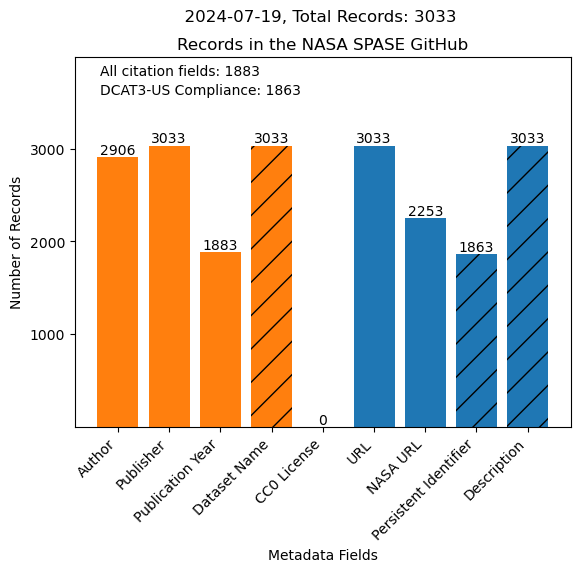

In [6]:
MetadataBarChart(conn, records)

['Author' 'Publisher' 'Publication Year' 'Dataset Name' 'CC0 License'
 'URL' 'NASA URL' 'Persistent Identifier' 'Description']
[2906 3033 1883 3033    0 3033 2253 1863 3033]


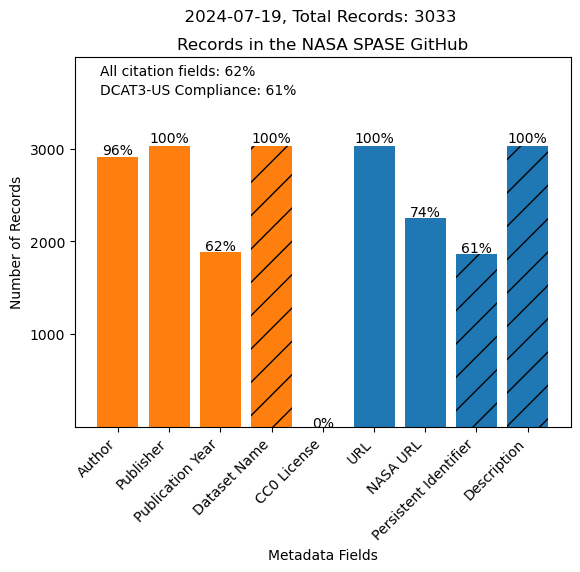

In [5]:
MetadataBarChart(conn, records, percent = True)

### Analysis for Records with NASA URLs

In [6]:
# same but only for records with NASA URLs
records = View(conn, All = False)
NASA_URL_Records = records["all"]
authorRecords = records["author"]
pubRecords = records["pub"]
pubYrRecords = records["pubYr"]
datasetNameRecords = records["datasetName"]
licenseRecords = records["license"]
urlRecords = records["url"]
NASAurlRecords = records["NASAurl"]
PIDRecords = records["PID"]
descriptionRecords = records["description"]
citationRecords = records["citation"]
complianceRecords = records["compliance"]

There are 2253 records with NASA URLs.
There are 2242 records with an author.
There are 2253 records with a publisher.
There are 1628 records with a publication year.
There are 2253 records with a dataset.
There are 0 records with a license.
There are 2253 records with a URL.
There are 2253 records with a NASA URL.
There are 1612 records with a persistent identifier.
There are 2253 records with a description.
There are 1628 records with citation info.
There are 1612 records that meet DCAT-US3 compliance.


['Author' 'Publisher' 'Publication Year' 'Dataset Name' 'CC0 License'
 'URL' 'NASA URL' 'Persistent Identifier' 'Description']
[2242 2253 1628 2253    0 2253 2253 1612 2253]


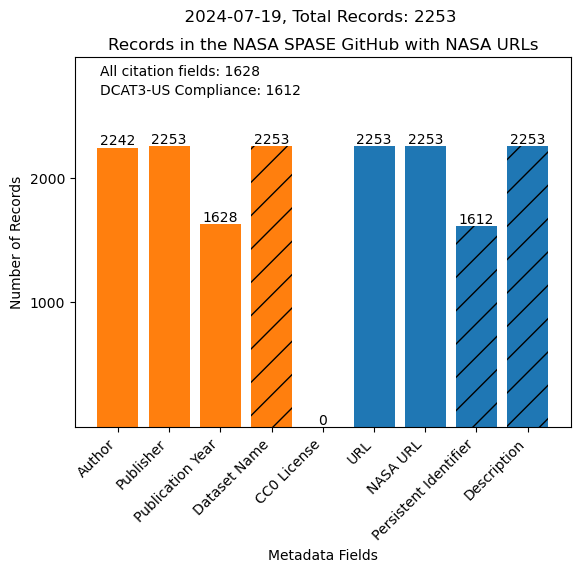

In [7]:
MetadataBarChart(conn, records, All = False)

['Author' 'Publisher' 'Publication Year' 'Dataset Name' 'CC0 License'
 'URL' 'NASA URL' 'Persistent Identifier' 'Description']
[2242 2253 1628 2253    0 2253 2253 1612 2253]


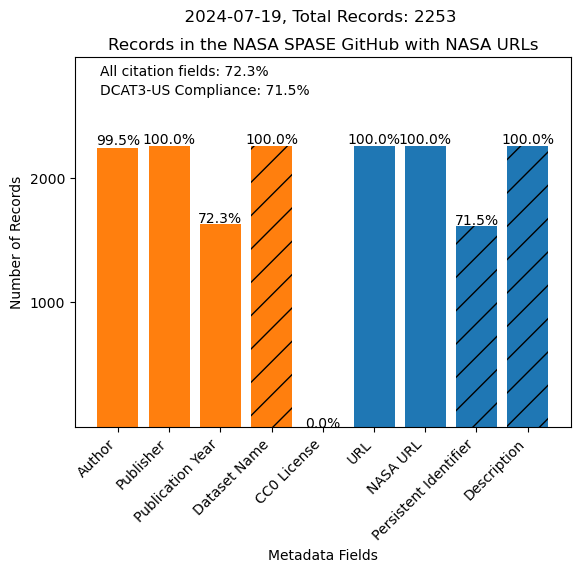

In [8]:
MetadataBarChart(conn, records, percent = True, All = False)

## Calculating the FAIR Scores
This code overwrites the default values placed in the TestResults table to have the actual FAIR Scores that are calculated according to the following algorithm:<br>

- +1 for author
- +1 for dataset name
- +1 for publication year
- +1 for publisher
- +1 for citation info
- +1 for description
- +1 for PID
- +1 for compliance
- +1 for license
- +1 for NASA URL <br>
======================= <br>
- Total Possible Points of 10

*Note that this alogrithm is expected to change*

If interested in viewing the FAIR Score for a particular record, refer to the column-specific queries section further below.

In [11]:
# reminder of how TestResults looks
# REPLACE w updated function to show just TestResults table
databaseInfo(conn)

The table MetadataEntries has columns:
['rowNum', 'SPASE_id', 'author', 'authorRole', 'publisher', 'publicationYr', 'datasetName', 'license', 'URL', 'prodKey', 'description', 'PID']

The table MetadataSources has columns:
['rowNum', 'SPASE_id', 'author_source', 'publisher_source', 'publication_yr_source', 'datasetName_source', 'license_source', 'datalink_source', 'description_source', 'PID_source']

The table TestResults has columns:
['rowNum', 'SPASE_id', 'FAIR_Score', 'FAIR_ScoreDate', 'MostRecent', 'has_author', 'has_pub', 'has_pubYr', 'has_datasetName', 'has_license', 'has_url', 'has_NASAurl', 'has_PID', 'has_desc', 'has_citation', 'has_compliance', 'Errors']

The table Records has columns:
['rowNum', 'SPASE_id', 'SPASE_Version', 'LastModified', 'SPASE_URL']



In [5]:
from Scripts import FAIRScorer

help(FAIRScorer)

Help on function FAIRScorer in module Scripts.SQLiteFun:

FAIRScorer(records, conn)
    Iterates through the has_x column names of the TestResults table to calculate the FAIR Score of all the records in
    the parameter. FAIR Score is calculated according to the algorithm described in the notebook. Once the FAIR score is 
    calculated, the FAIR_Score, MostRecent, and FAIR_ScoreDate columns are updated for that record.
    
    :param records: A list of all the links in table.
    :type records: list
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: None



In [6]:
# calculate FAIR scores for all records
FAIRScorer(allRecords, conn)

In [7]:
from Scripts import FAIR_Chart

help(FAIR_Chart)

Help on function FAIR_Chart in module Scripts.PlotScripts:

FAIR_Chart(conn, All=True)
    Executes a SQLite SELECT statement to collect all FAIR Scores and displays a bar chart showing the 
    number of records for each FAIR Score. This does so by using NumPy arrays within a MatPlotLib function.
    The default value for All is True, which uses data from all the records in the database.
    Passing False to the All parameter performs the same, but only for the records with NASA URLs.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param All: A boolean determining whether or not to use all records in the database or only those with NASA URLs.
    :type All: Boolean
    :return: None



### FAIR Analysis for All Records

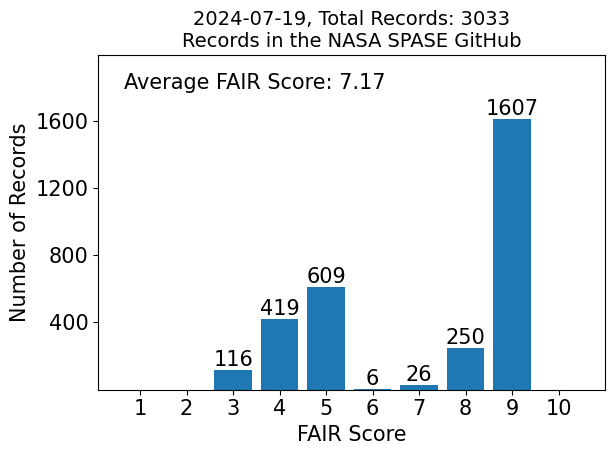

In [3]:
# display FAIR Score Distribution Chart
# all records
FAIR_Chart(conn)

### FAIR Analysis for Records with NASA URLs

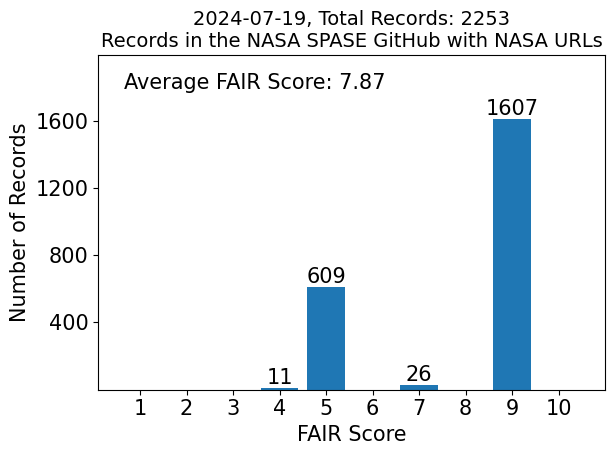

In [4]:
# only records with NASA URLs
FAIR_Chart(conn, All = False)

## How to do your own queries 
This section gives examples of how to query the database for row specific and column specific queries. Also provided are brief explanations of some of the SQLite syntax and also an example of a complex query for both categories. <br>

If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Disclaimer: Not all authors are provided, as checks were only done to find if an allowed author exists.* 
<br>
**Also note that when a SPASE record has multiple product keys for one URL or multiple URLs in general, each URL/product key gets their own entry into the table. This is why there may be 'duplicate entries' in the database.**

### Record Specific Queries

This section describes how to get data with queries based on records/rows.

In [5]:
from Scripts import execution

help(execution)

Help on function execution in module Scripts.SQLiteFun:

execution(stmt, conn, number='single')
    Connects to the given SQLite database, creates a cursor object, and calls the execute method 
    with the stmt argument. The number argument has default value of single, which will format the 
    return correctly when selecting only one item. Otherwise pass 'multiple' as the argument when 
    selecting more than one item. Calls the fetchall method to get all rows returned by the 
    statement that was executed. This also displays error messages if any arise. Lastly, it returns 
    the values of the matching items from the SQLite SELECT statement in a list.
    
    :param stmt: A string of the SQLite statement to be executed.
    :type stmt: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param number: An string that formats the return based on how many items are being selected
    :type number: String
    :return: The list of the 

> Ex: How to get a ResourceID

> - Use """SELECT columnName FROM TableName WHERE columnName = x""" where x is of proper data type.

In [10]:
stmt = """ SELECT SPASE_id FROM MetadataEntries WHERE rowNum = 10 """
execution(stmt, conn)

['spase://NASA/NumericalData/Interball-2/IMAP3/PT120S']

> Ex: Get ResourceID by specifying the xml file name

> - Use "LIKE '%text%'" instead of '= x' for when you need to query on partial info.

> - SQLite uses the '%' as the multi-character wildcard and '_' as the single character wildcard.

> - Use DISTINCT to prevent duplicate rows.

In [11]:
stmt = """ SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE SPASE_id LIKE '%IMAP3/PT120S' """
execution(stmt, conn)

['spase://NASA/NumericalData/Interball-2/IMAP3/PT120S']

> Ex: Searching table for ResourceID using a specific value of a column

In [12]:
ds = "Interball Aurora MAG 2-min Key Parameters"
stmt = f""" SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE datasetName = '{ds}' """
execution(stmt, conn)

['spase://NASA/NumericalData/Interball-2/IMAP3/PT120S']

> Ex: How to get all data for a SPASE record using the ResourceID
> - Put 'multiple' as the second optional arg for execution when selecting more than 1 item.

>> This example prints out the following data in a list of tuples, where each tuple is a distinct row in the table. The tuples follow the following printout format:
>> - rowNum
>> - SPASE_id
>> - author
>> - authorRole (if relevant)
>> - publisher
>> - publication year
>> - datasetName
>> - license
>> - url (if NASA URL)
>> - prodKey
>> - description
>> - PID

In [8]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT * FROM MetadataEntries WHERE SPASE_id = '{ID}' """
rows = execution(stmt, conn, "multiple")
rows

[(9,
  'spase://NASA/NumericalData/Interball-2/IMAP3/PT120S',
  'spase://SMWG/Person/Vladislav.M.Petrov',
  'GeneralContact',
  'NASA/GSFC/SPDF',
  '',
  'Interball Aurora MAG 2-min Key Parameters',
  'Open',
  'ftps://spdf.gsfc.nasa.gov/pub/data/interball/aurora/mfi/',
  '',
  'description found',
  ''),
 (11,
  'spase://NASA/NumericalData/Interball-2/IMAP3/PT120S',
  'spase://SMWG/Person/Vladislav.M.Petrov',
  'GeneralContact',
  'NASA/GSFC/SPDF',
  '',
  'Interball Aurora MAG 2-min Key Parameters',
  'Open',
  'https://cdaweb.gsfc.nasa.gov/cgi-bin/eval2.cgi?dataset=IA_K0_MFI&index=sp_phys',
  'IA_K0_MFI',
  'description found',
  ''),
 (12,
  'spase://NASA/NumericalData/Interball-2/IMAP3/PT120S',
  'spase://SMWG/Person/Vladislav.M.Petrov',
  'GeneralContact',
  'NASA/GSFC/SPDF',
  '',
  'Interball Aurora MAG 2-min Key Parameters',
  'Open',
  'https://cdaweb.gsfc.nasa.gov/hapi',
  'IA_K0_MFI',
  'description found',
  ''),
 (10,
  'spase://NASA/NumericalData/Interball-2/IMAP3/PT120S

> To get the actual description, use the SPASE_DataPrinter function

In [9]:
from Scripts import MetadataPrinter

help(MetadataPrinter)

Scraping /home/jovyan/NASA/NumericalData/Interball-2/IMAP3/PT120S.xml
The description is Interball Auroral Magnetometer, 2-min key parameters, field intensity and index which was obtained from NumericalData/ResourceHeader/Description


In [ ]:
MetadataPrinter(ID, fields = ["description"])

> Ex: How to get the Fair Score for a record

In [14]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT DISTINCT(FAIR_Score) FROM TestResults WHERE SPASE_id = '{ID}' """
execution(stmt, conn)

[5]

> Complex example: Selecting multiple items from multiple tables by using the ResourceID

> - Notice we use commas for multiple items and INNER JOINS when it is over multiple tables.

In [15]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
rows = execution(f""" SELECT author, MetadataSources.author_source, Records.SPASE_URL 
            FROM MetadataEntries
                INNER JOIN MetadataSources USING (SPASE_id)
                INNER JOIN Records USING (SPASE_id)
            WHERE SPASE_id = '{ID}';""", conn, 'multiple')
print(rows[0])

('spase://SMWG/Person/Vladislav.M.Petrov', 'NumericalData/ResourceHeader/Contact/PersonID', 'https://github.com/hpde/NASA/blob/master/NumericalData/Interball-2/IMAP3/PT120S.xml')


### Column Specific Queries
This section describes how to get data with queries based on the column values.

> Ex: How many records do not have a NASA URL?

In [6]:
stmt = """SELECT COUNT(DISTINCT(SPASE_id)) FROM TestResults WHERE has_NASAurl = 0"""
execution(stmt, conn)

[780]

> Ex: What are some examples of SPASE_id's of the records that do not have a NASA URL?
> - Use optional LIMIT x at end to limit how many items are selected.

In [17]:
stmt = """SELECT DISTINCT(SPASE_id) FROM TestResults WHERE has_NASAurl = 0 LIMIT 10"""
execution(stmt, conn)

['spase://NASA/NumericalData/ACE/EPAM/CA60/PHA/Ion/SEP_Event/MatrixData/PT17M',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/PHA/Sectored/Ion/SEP_Event/CountRates/PT17M',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/P1D',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT11.5S',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT1H',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT5M',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/Z_Channels/SpacecraftFrame/Sectored/Ion/CountRates/P1D',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/Z_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT11.5S',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/Z_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT1H',
 'spase://NASA/NumericalData/ACE/EPAM/CA60/Z_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT5M']

> Ex: How many records have 3 out of 4 fields needed for citation?
> - Use AND and OR operators just like in programming languages.

In [18]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults 
                WHERE (has_author = 1 
                AND has_datasetName = 1
                AND has_pubYr = 1)
                OR (has_author = 1 
                AND has_datasetName = 1
                AND has_pub = 1)
                OR (has_author = 1 
                AND has_pub = 1
                AND has_pubYr = 1)
                OR (has_datasetName = 1 
                AND has_pub = 1
                AND has_pubYr = 1)"""
execution(stmt, conn)

[2906]

> Ex: How many records have SDAC or SPDF as a publisher?

In [15]:
SDAC_stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM MetadataEntries 
                        WHERE (publisher LIKE "%SDAC" OR publisher LIKE 
                                "%Solar Data Analysis Center")"""
SPDF_stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM MetadataEntries 
                        WHERE (publisher LIKE "%SPDF" OR publisher LIKE 
                                "%Space Physics Data Facility")"""
execution(SPDF_stmt, conn)

[2185]

> Ex: How did records in a certain directory do in terms of FAIR scores?
> - Notice that since we are only interested in the most up-to-date FAIR scores, we add the "MostRecent = 'T'" condition.

In [19]:
stmt = """SELECT DISTINCT(SPASE_id), FAIR_Score FROM TestResults 
                WHERE SPASE_id LIKE '%/ACE/%' AND MostRecent = 'T' LIMIT 10"""
print("Format is as follows: (SPASE_id, FAIR_Score)")
execution(stmt, conn, 'multiple')

Format is as follows: (SPASE_id, FAIR_Score)


[('spase://NASA/NumericalData/ACE/Attitude/Definitive/PT1H', 9),
 ('spase://NASA/NumericalData/ACE/CRIS/L2/P1D', 9),
 ('spase://NASA/NumericalData/ACE/CRIS/L2/PT1H', 9),
 ('spase://NASA/NumericalData/ACE/EPAM/CA60/PHA/HeavyIon/Spectra/P1D', 9),
 ('spase://NASA/NumericalData/ACE/EPAM/CA60/PHA/Ion/SEP_Event/MatrixData/PT17M',
  8),
 ('spase://NASA/NumericalData/ACE/EPAM/CA60/PHA/Sectored/Ion/SEP_Event/CountRates/PT17M',
  8),
 ('spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/P1D',
  8),
 ('spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT11.5S',
  8),
 ('spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT1H',
  8),
 ('spase://NASA/NumericalData/ACE/EPAM/CA60/W_Channels/SpacecraftFrame/Sectored/Ion/CountRates/PT5M',
  8)]

> Ex: How many records have a FAIR Score of x?

In [20]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults WHERE FAIR_Score = 9 """
execution(stmt, conn)

[1607]

> Complex Ex: What records have at least 2 of the desired fields?
> - Notice we use f-strings to concatenate strings instead of retyping text.

In [21]:
has_citation = """author NOT LIKE ""
                    AND datasetName NOT LIKE ""
                    AND publicationYr NOT LIKE ""
                    AND publisher NOT LIKE "" """
citationStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_citation};"""
has_compliance = """ description NOT LIKE ""
                AND datasetName NOT LIKE ""
                AND PID NOT LIKE "" """
complianceStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_compliance};"""

# at least 2 fields
AL2Stmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE ({has_citation}
                AND
                    {has_compliance}) 
                OR
                    ({has_citation}
                AND
                    PID NOT LIKE "")
                OR
                    ({has_citation}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND 
                    PID NOT LIKE "")
                OR  
                    (PID NOT LIKE ""
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%") LIMIT 10;"""

execution(AL2Stmt, conn)

['spase://NASA/DisplayData/POLAR/VIS/PT300S',
 'spase://NASA/DisplayData/SDO/AIA/SSC/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-A/SECCHI/Cor1/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-A/SECCHI/Cor2/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-A/SECCHI/EUVI/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-B/SECCHI/Cor1/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-B/SECCHI/Cor2/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-B/SECCHI/EUVI/CarringtonMaps',
 'spase://NASA/DisplayData/UCLA/Global-MHD-code/mS1-Vx/PT10S',
 'spase://NASA/DisplayData/UCLA/Global-MHD-code/mS2-Bz/PT10S']

## How to Backup Database
This code generates a backup copy of the live database into a file specified by the filename variable.

*Note that this cannot be run if there is a pending SQL statement or open transaction running.*

In [8]:
from Scripts import executionALL
help(executionALL)

Help on function executionALL in module Scripts.SQLiteFun:

executionALL(stmt, conn)
    Connects to the given SQLite database, creates a cursor object, and calls the execute method 
    with the stmt argument. This also displays error messages if any arise.
    
    :param stmt: A string of the SQLite statement to be executed.
    :type stmt: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: None



In [ ]:
filename = "./SPASE_Data_20240716_backup.db"
stmt = f"VACUUM main INTO '{filename}'"
executionALL(stmt, conn)